# Tutorial on neuronal package

**names: Amelia Paine, Han Sae Jung**

## Motivation

Commonly, electrophysiological data is processed by a bandpass filter and a moving average. Afterwards, spike times of neuronal signals are determined by thresholding or template-based methods. Then, the peak amplitudes of the identified spikes are quantified by simply subtracting the maximum amplitude of the signal from the mean or median of the baseline. While these methods are computationally effective and have become a standard protocol for analyzing electrophysiological data, they render phase distortions to the signals to a certain extent; hence, we lose some information about the signals along the way [1, 2]. Furthermore, these methods do not give us statistically justified uncertainty estimates of the parameters.

Our goal is to analyze these data in a more statistically rigorous manner. We have adapted/modified a generative model proposed by Merel et al. [2] Using this model, we will infer the spike times and peak amplitudes of postsynaptic potentials (PSP) in a Bayesian manner. This model can be used even when the baseline varies in a non-periodic manner.

## Generative Model from Merel et al. [2]

Our model is adpated from the model suggested by Merel et al.

Their generative model is the following:

$$y_t = \sum_{i=1}^{n} a_i f_i(t - t_i) + b + \epsilon_t$$

$$f_i(t') = \exp(-t' / \tau_i^d) - \exp(-t' / \tau_i^r) \: \text{for} \: t' \ge 0$$ 

$$\epsilon_t = \sum_{j=1}^{p} \phi_j \epsilon_{t-j} + u_t , \: u_t \approx N(0, \sigma^2)$$ 

$\text{where}$ 

$y_t \equiv \text{observed voltage trace}$, 

$t_i \equiv \text{spike time of} \: i^{th} \: \text{PSP}$, 

$n \equiv \text{number of PSPs}$, 

$b \equiv \text{constant baseline}$, 

$f_i(t') \equiv \text{mathematical trial function of PSP}$, 

$\epsilon_t \equiv \text{general AR(p) autoregressive model of the noise}$, 

$u_t \equiv \text{Gaussian i.i.d. noise}$, 

$\tau_i^d \equiv \text{decay time constant of} \: i^{th} \: \text{PSP}$, 

$\tau_i^r \equiv \text{rise time constant of} \: i^{th} \: \text{PSP}$, 

$a_i \equiv \text{constant related to the peak amplitude for} \: i^{th} \: \text{PSP}$


## Our Generative Model for PSP's

The generative model described above assumes a constant baseline. However, there is usually a varying baseline. Because the baseline tends to vary non-periodically, even if there were a mathematical function that can be used to model the baseline, it's likely to be incredibly complicated. Instead, we will account for the varying baseline by piecewise, linearly varying segments (in the form $mx + b$). Also, instead of considering a general AR(p) noise process, we will focus on AR(0) process (i.e. Gaussian i.i.d. noise).

$$y_t = H(t_1 - t) \cdot (b_{start} + \frac{b_1 - b_{start}}{t_1 - t_{start}} \cdot (t - t_{start})) \: + $$ 

$$\sum_{i=1}^{n-1} H(t - t_i) \cdot (a_i f_i(t - t_i) + H(t_{i+1} - t) \cdot (b_i + \frac{b_{i+1} - b_{i}}{t_{i+1} - t_i} \cdot (t - t_i))) \: +$$
$$H(t - t_{n}) \cdot (a_n f_n(t - t_n) + b_{n} + \frac{b_{end} - b_n}{t_{end} - t_{n}} \cdot (t - t_{n})) + \epsilon_t$$

$H(x) \equiv \text{Heaviside step function such that} \: H(x \ge 0) = 1 \: \text{and} \: H(x < 0) = 0$

$f_i(t') = \exp(-t' / \tau_i^d) - \exp(-t' / \tau_i^r) \: \text{for} \: t' \ge 0$

$\epsilon_t \approx N(0, \sigma^2)$

$\text{where}$ 

$y_t \equiv \text{observed voltage trace}$,

$f_i(t') \equiv \text{mathematical trial function of} \: i^{th} \: \text{PSP}$,

$\epsilon_t \equiv \text{Gaussian i.i.d. noise}$, 

$\sigma \equiv \text{standard deviation of the Gaussian i.i.d. noise}$

$t_{start} \equiv \text{start time of the voltage trace}$,

$t_{end} \equiv \text{end time of the voltage trace}$

$t_i \equiv \text{spike time of} \: i^{th} \: \text{PSP}$, 

$n \equiv \text{number of PSPs}$, 

$b_{start} \equiv \text{voltage of the baseline at} \: t_{start}$,

$b_i \equiv \text{voltage of the baseline at} \: t_i$, 

$b_{end} \equiv \text{voltage of the baseline at} \: t_{end}$,

$\tau_i^d \equiv \text{decay time constant of} \: i^{th} \: \text{PSP}$, 

$\tau_i^r \equiv \text{rise time constant of} \: i^{th} \: \text{PSP}$, 

$a_i \equiv \text{constant related to the peak amplitude of} \: i^{th} \: \text{PSP}$

By differentiating $f_i(t')$ with respect to $t'$, we find that the maximum of the signal occurs at $t_i = t_i^{max}$:

$$t_i^{max} = \frac{ln(\tau_i^d / \tau_i^r)}{1 / \tau_i^r - 1 / \tau_i^d}$$

Then, 

$$a_i^{peak} = a_i \cdot f_i(t^*) - \frac{b_{i+1} - b_{i}}{t_{i+1} - t_i} \cdot (t_i^{max} - t_i)$$

In order for our model to be successful, we need to somehow account for the following noise sources:

**Examples of noise sources [2]: electrical hardware, analog to digital conversion, membrane oscillations and local field potential from other neurons, solution in which neurons are cultured, changes in resistance between the electrode and the interior of the neuron**

Since our noise is a mixture of a wide range of sources, we can argue that Gaussian i.i.d. noise model is valid (on the basis of central limit theorem) upto a certain extent.

Since we are assuming AR(0) case (Gaussian i.i.d. noise), our likelihood function is:

$$ p(Y|\Theta) = \prod_{t=1}^{T} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y_t-\hat{y_t})^2}{2\sigma^2}\right)$$

where $\hat{y_t}$ refers to the predicted noiseless trace $y_t - \epsilon_t$ and $\Theta$ refers to the parameters

Given this model, the log-posterior $L(\Theta|Y)$ is:

$$L(\Theta|Y) \propto ln p(Y|\Theta) \: + \: ln p(\Theta)$$

## Our Test Data

Our test data set is a voltage trace from an intracellular measurement on an $\textit{in vitro}$, dense neuronal culture, which consists of rat cortical neurons. The measurement was done on a CMOS nanoelectrode array developed by Abbott et al. at Harvard University [3]. The voltage signal and time are in units of mV and second, respectively. The sampling frequency is 9415 Hz. 

In [6]:
#Standard imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

## Importing Data

Let's import the data using a NeuronalData object. This stores the imported data in a pandas DataFrame under columns T (time) and V (voltage signal).

The user may specify any file path pointing to correctly-formatted data, but in this case we will use the example data provided with the package. num_psp, the number of PSPs in the data, should also be specified at import.

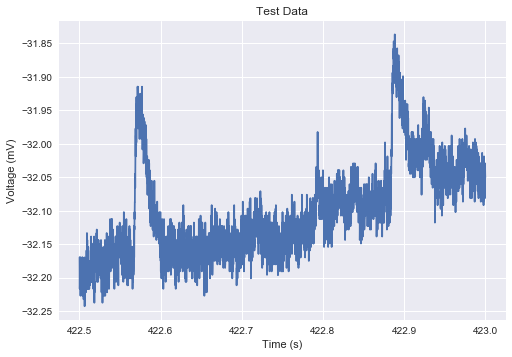

In [7]:
#our package import
import neuronal

two_psp = neuronal.NeuronalData(neuronal.get_example_data_file_path('two_PSP_data.txt'), num_psp=2)

plt.plot(two_psp.data['T'], two_psp.data['V'])
plt.title('Test Data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

## Inference Step 1: chi-by-eye fit

Without a reasonably good initial guess, pymc3 cannot converge onto a reasonable set of parameters. By following the following protocol, we found out that it's quite easy to get a good initial guess from a simple chi-by-eye fit in a short amount of time. The specific numbers below only apply to our particular dataset; however, assuming a comparable experimental setup (i.e. high density multielectrode array with an on-chip amplifier [3]), these numbers should be a good guideline within an order of magnitude.

1) First set $\textbf{tau_d}$ to 0.01 s and $\textbf{tau_r}$ to 0.001 s for all the peaks. Actual values tend to be within an order of magnitude.

2) Choose $\textbf{t_psp}$ based on the plot; it's the time at which the spike begins. It's pretty straightforward to choose this value from the plot.

3) Choose $\textbf{sigma}$ = 0.026 mV. The actual value tends to be within a factor of 1.5. Note that sigma doesn't affect the chi-by-eye fit; it only serves as an inital guess for the pymc3 calculation.

4) Choose $\textbf{b}$ for each PSP. It's the voltage value corresponding to each peak's $\textbf{t_psp}$. This is also straightforward to see from the plot.

5) Choose $\textbf{b_start}$ as the voltage value somewhere in the middle of the baseline at the starting time. Likewise, choose $\textbf{b_end}$ as the voltage value somewhere in the middle of the baseline at the end time.

6) Based on the plot, initialize $\textbf{a}$ (constant related to peak amplitude) by roughly subtracting the rough guess of the peak amplitude from the baseline. Then, adjust a until the chi-by-eye fit looks good. If the fit cannot become reasonable by simply adjusting $\textbf{a}$, adjust $\textbf{tau_r}$ and $\textbf{tau_d}$ appropriately as well. Some additional fine tuning of $\textbf{t_psp}$ and $\textbf{b}$ can help as well.

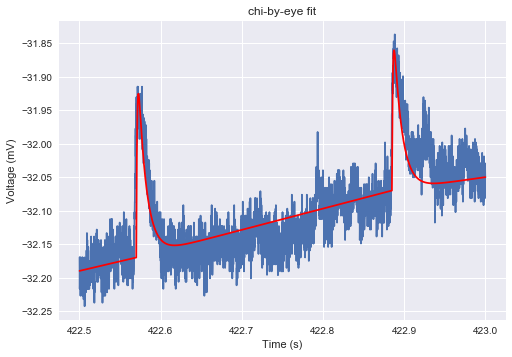

In [8]:
t = two_psp.data['T'].values
v = two_psp.data['V'].values

sigma = 0.026
b_start = -32.19
b = [-32.17, -32.07]
b_end = -32.05
a = [0.35, 0.3]
t_psp = [422.57, 422.885]
tau_d = [0.01, 0.01]
tau_r = [0.001, 0.001]

model = neuronal.psp_model(two_psp, b_start, b, b_end, a, t_psp, tau_d, tau_r)

plt.plot(t, v)
plt.plot(t, model, c='r')
plt.title('chi-by-eye fit')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

## Inference Step 2: parameter estimation using pymc3

psp_fit employs pymc3 [4], a Python package that performs Hamiltonian MC parameter estimation using No-U-Turn Sampler (NUTS). This converges best when a reasonable initial guess is supplied.

| Parameter | Description |
|------|------|
| sigma | standard deviation of Gaussian i.i.d. noise (unit: mV) |
| b_start | voltage of the baseline at the starting time of the data (unit: mV) |
| b | list of voltages of the baselines at PSP spike times (unit: mV) |
| b_end | voltage of the baseline at the end time of the data (unit: mV) |
| a | list of constants related to peak amplitudes for PSP's (unit: mV) |
| t_psp | list of spike times for PSP's (unit: s) |
| tau_d | list of decay time constants for PSP's (unit: s) |
| tau_r | list of rise time constants for PSP's (unit: s) |

There are 5 parameters (b, a, t_psp, tau_d, tau_r) for each PSP and 3 parameters (sigma, b_start, and b_end) that are always present regardless of the number of PSP's. For example, for a voltage trace containing 2 PSP's, there are 13 parameters.

In [9]:
#The function behind the scenes
neuronal.psp_fit??

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r, tau_d, t_psp, a, sigma, b, b_end, b_start]
Sampling 2 chains: 100%|██████████| 1000/1000 [04:14<00:00,  2.19draws/s]
The acceptance probability does not match the target. It is 0.9640756307286262, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9514417164204162, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


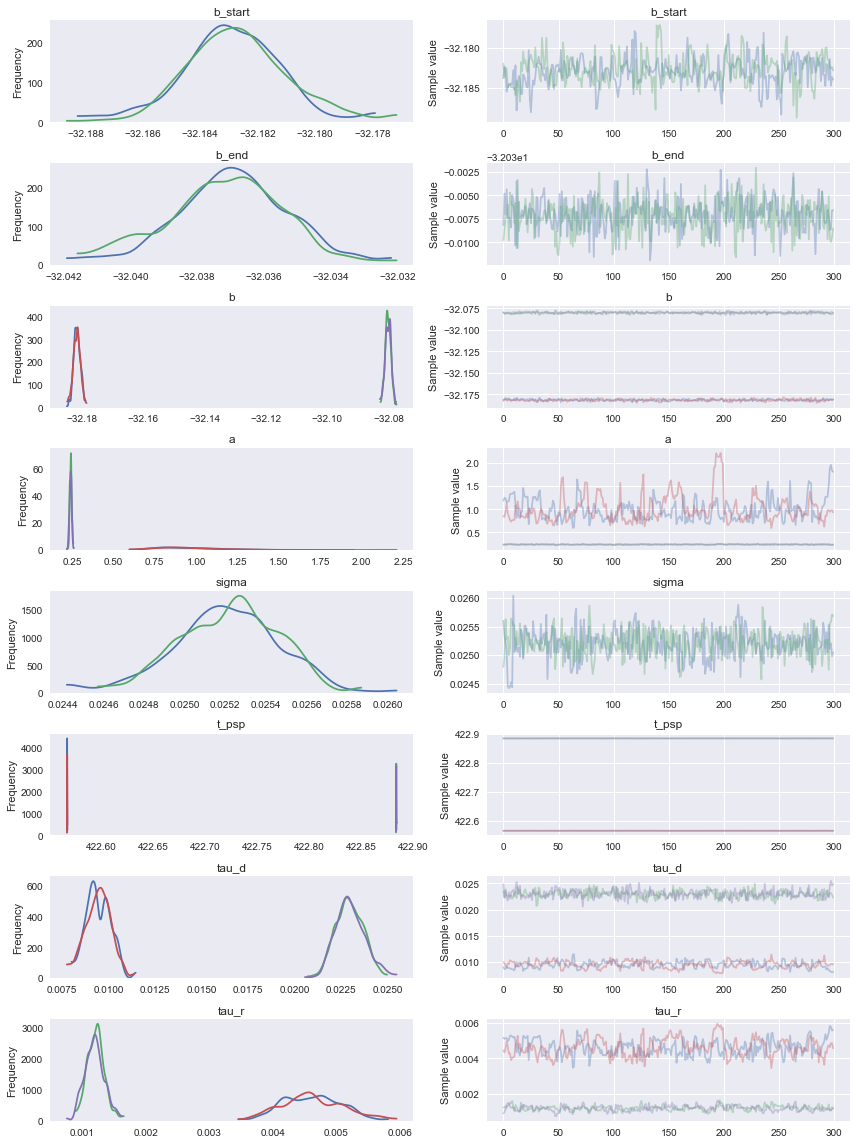

In [16]:
initial_guess = {'sigma': sigma, 'b_start': b_start, 'b': b, 'b_end': b_end, 
                 'a': a, 't_psp': t_psp, 'tau_d': tau_d, 'tau_r': tau_r}

two_psp_df = neuronal.psp_fit(two_psp, 300, initial_guess, seed=1000, tune=200, cores=2)

For each PSP, we report t_psp and peak_amp in terms 68% credible interval centered around the median.
Then, we plot the marginal distribution of the peak amplitude for each PSP.

The best fit value for t_psp__0 is 422.5669 + 0.0001 - 0.0001
The best fit value for peak_amp__0 is 0.2408 + 0.0037 - 0.0031
The best fit value for t_psp__1 is 422.8839 + 0.0001 - 0.0001
The best fit value for peak_amp__1 is 0.1936 + 0.0034 - 0.0032


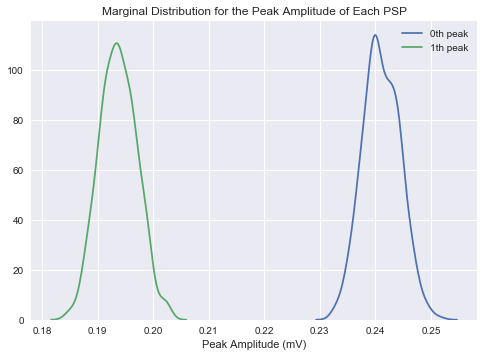

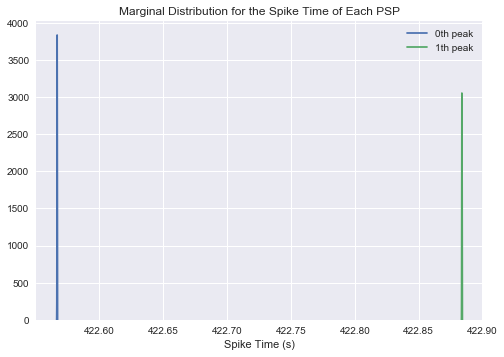

In [18]:
num_psp = two_psp.num_psp
t_end = two_psp.data['T'].iloc[-1]
fig1 = plt.figure()
for i in range(num_psp):
    df = neuronal.calculate_peak_amplitudes(i, two_psp_df, t_end, num_psp)
    quantile_df = neuronal.get_quantiles(df.loc[:, ['t_psp__' + str(i), 'peak_amp__' + str(i)]])
    neuronal.report_best_fit(quantile_df, 't_psp__' + str(i))
    neuronal.report_best_fit(quantile_df, 'peak_amp__' + str(i))
    sns.kdeplot(df['peak_amp__' + str(i)], label=str(i)+'th peak')
plt.xlabel('Peak Amplitude (mV)')
plt.title('Marginal Distribution for the Peak Amplitude of Each PSP')
plt.show()

fig2 = plt.figure()
for i in range(num_psp):
    sns.kdeplot(df['t_psp__' + str(i)], label=str(i)+'th peak')
plt.xlabel('Spike Time (s)')
plt.title('Marginal Distribution for the Spike Time of Each PSP')
plt.show()

Here's the plot of our model with the best fit (median) parameters on our data.

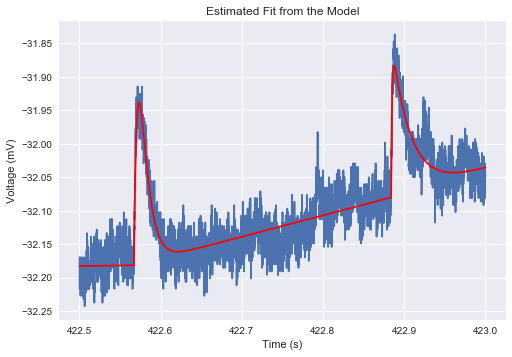

In [21]:
neuronal.plot_fit(two_psp, two_psp_df)

## Using Reduced Data for Faster Calculation

To speed up the calculation, we can reduce the number of data points. As we will show, this leads to broader marginal distributions of the parameters. However, as long as we don't cut down the data too much, we can still get good estimates of our parameters that agree to the estimate obtained from the calculation on the full, original data within the 68% credible interval range.

We can reduce the number of data points in two ways: $\textbf{decimate}$ method or $\textbf{randomly_reduce}$ method. $\textbf{decimate}$ method returns a NeuronalData object with every nth data point; so number of data points is reduced by a factor of n. On the other hand, $\textbf{randomly_reduce}$ method randomly removes data points such that the number of data points is reduced by a factor of n. 

Depending on the data, one method might be more effective than the other method.

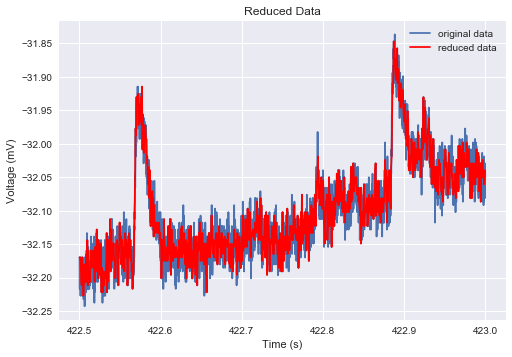

In [22]:
#Reduce the number of data points by a factor of 5 using decimate method
two_psp_reduced = two_psp.decimate(5)

reduced_t = two_psp_reduced.data['T'].values
reduced_v = two_psp_reduced.data['V'].values

plt.plot(t, v, label='original data')
plt.plot(reduced_t, reduced_v, c='r', label='reduced data')
plt.title('Reduced Data')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

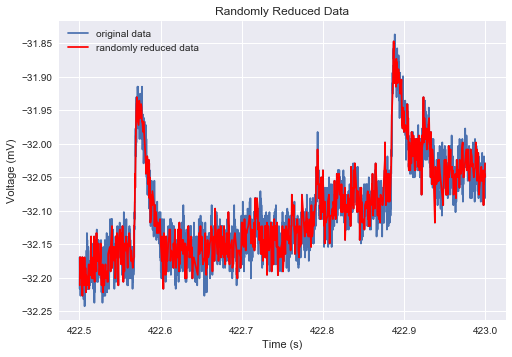

In [23]:
#Reduce the number of data points by a factor of 5 using randomly_reduce method
two_psp_randomly_reduced = two_psp.randomly_reduce(5, seed=1000)

randomly_reduced_t = two_psp_randomly_reduced.data['T'].values
randomly_reduced_v = two_psp_randomly_reduced.data['V'].values

plt.plot(t, v, label='original data')
plt.plot(randomly_reduced_t, randomly_reduced_v, c='r', label='randomly reduced data')
plt.title('Randomly Reduced Data')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

It is important that we don't cut down the data excessively so that our result from parameter estimation leads to a sensible fit with the original data.

Let's see if reduced data leads to a sensible estimate of the parameters.

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r, tau_d, t_psp, a, sigma, b, b_end, b_start]
Sampling 2 chains: 100%|██████████| 1000/1000 [01:06<00:00, 10.26draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9290233575211977, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9015973983495752, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


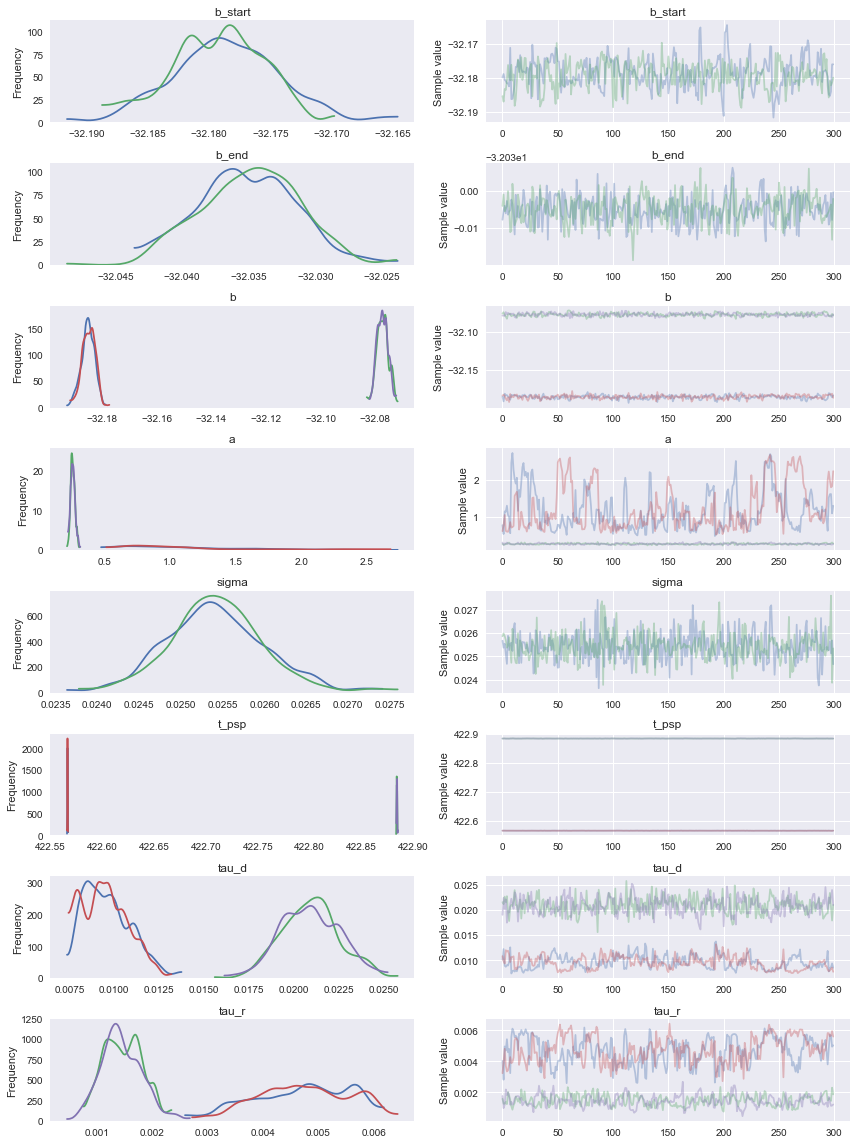

In [15]:
#same set of initial guess as above
initial_guess = {'sigma': sigma, 'b_start': b_start, 'b': b, 'b_end': b_end, 
                 'a': a, 't_psp': t_psp, 'tau_d': tau_d, 'tau_r': tau_r}

two_psp_reduced_df = neuronal.psp_fit(two_psp_reduced, 300, initial_guess, seed=1000, tune=200, cores=2)

The best fit value for t_psp__0 is 422.5668 + 0.0002 - 0.0002
The best fit value for peak_amp__0 is 0.2490 + 0.0072 - 0.0068
The best fit value for t_psp__1 is 422.8840 + 0.0003 - 0.0003
The best fit value for peak_amp__1 is 0.1937 + 0.0080 - 0.0072


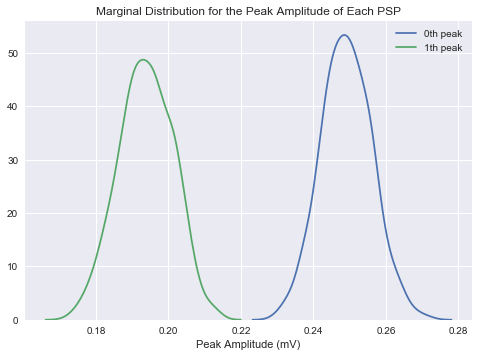

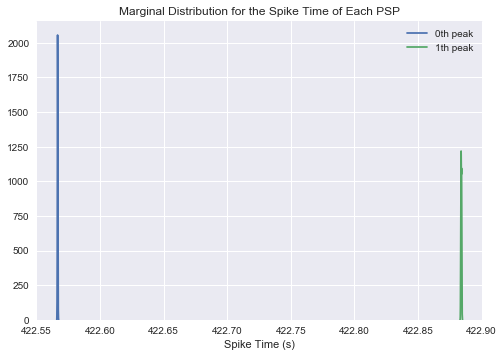

In [16]:
num_psp = two_psp_reduced.num_psp
t_end = two_psp_reduced.data['T'].iloc[-1]
fig1 = plt.figure()
for i in range(num_psp):
    df = neuronal.calculate_peak_amplitudes(i, two_psp_reduced_df, t_end, num_psp)
    quantile_df = neuronal.get_quantiles(df.loc[:, ['t_psp__' + str(i), 'peak_amp__' + str(i)]])
    neuronal.report_best_fit(quantile_df, 't_psp__' + str(i))
    neuronal.report_best_fit(quantile_df, 'peak_amp__' + str(i))
    sns.kdeplot(df['peak_amp__' + str(i)], label=str(i)+'th peak')
plt.xlabel('Peak Amplitude (mV)')
plt.title('Marginal Distribution for the Peak Amplitude of Each PSP')
plt.show()

fig2 = plt.figure()
for i in range(num_psp):
    sns.kdeplot(df['t_psp__' + str(i)], label=str(i)+'th peak')
plt.xlabel('Spike Time (s)')
plt.title('Marginal Distribution for the Spike Time of Each PSP')
plt.show()

As you can see, the marginal distributions of our parameters became broader; in other words, our uncertainty range is now greater for the parameters. Nevertheless, the parameter estimates from the reduced data agree with those from the original data within the 68% credible interval range. Hence the parameter estimates seem reasonable.

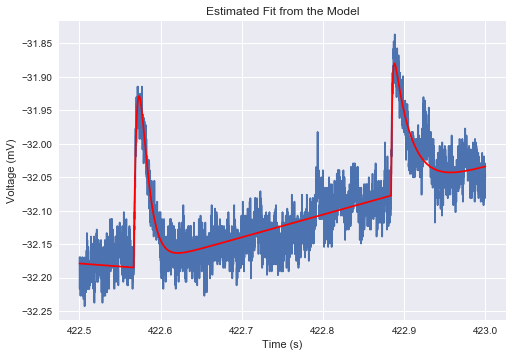

In [17]:
neuronal.plot_fit(two_psp, two_psp_reduced_df)

The resulting best fit parameters from the data reduced with the $\textbf{decimate}$ method seems to lead to a reasonable fit on the original data. 

Now, let's test whether the inference works well on the randomly reduced data as well.

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r, tau_d, t_psp, a, sigma, b, b_end, b_start]
Sampling 2 chains: 100%|██████████| 1000/1000 [01:21<00:00,  9.87draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9030845463436301, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9100042642487289, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


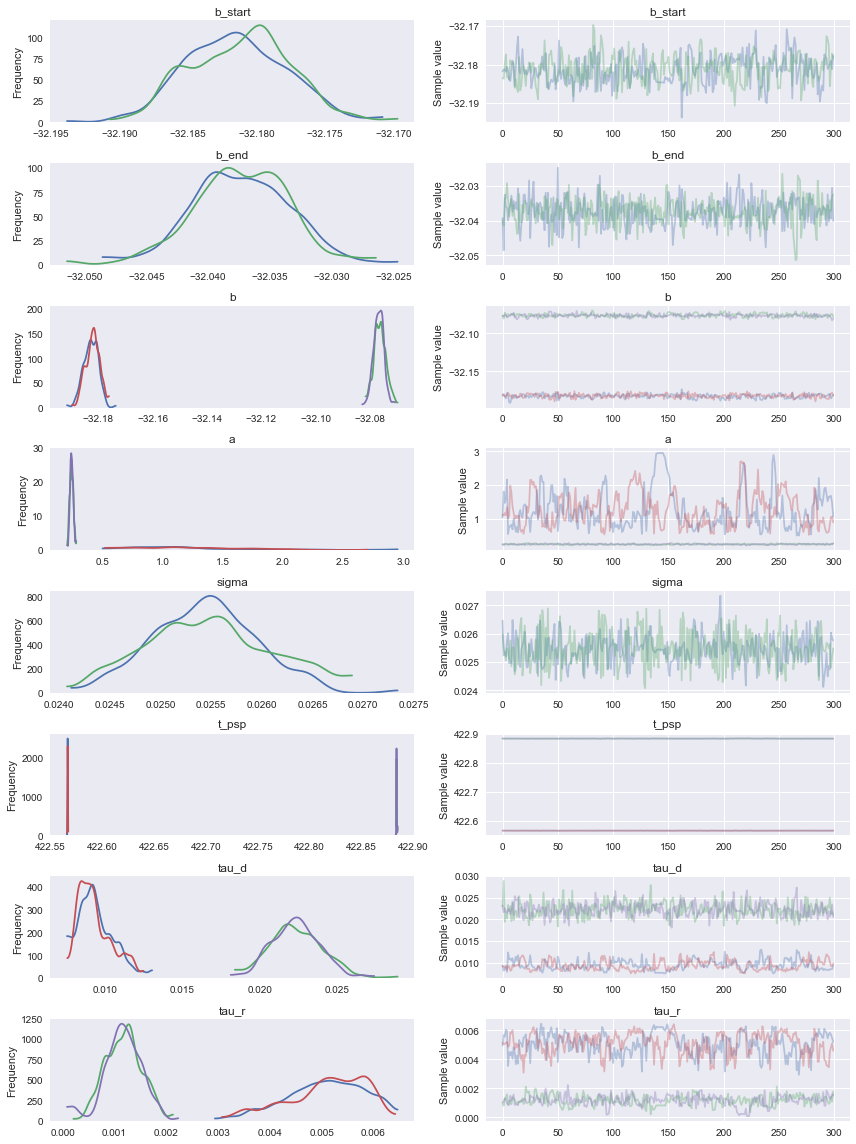

In [11]:
#same set of initial guess as above
initial_guess = {'sigma': sigma, 'b_start': b_start, 'b': b, 'b_end': b_end, 
                 'a': a, 't_psp': t_psp, 'tau_d': tau_d, 'tau_r': tau_r}

two_psp_randomly_reduced_df = neuronal.psp_fit(two_psp_randomly_reduced, 300, initial_guess, seed=1000, tune=200, cores=2)

The best fit value for t_psp__0 is 422.5668 + 0.0002 - 0.0002
The best fit value for peak_amp__0 is 0.2376 + 0.0072 - 0.0074
The best fit value for t_psp__1 is 422.8838 + 0.0002 - 0.0002
The best fit value for peak_amp__1 is 0.1923 + 0.0077 - 0.0071


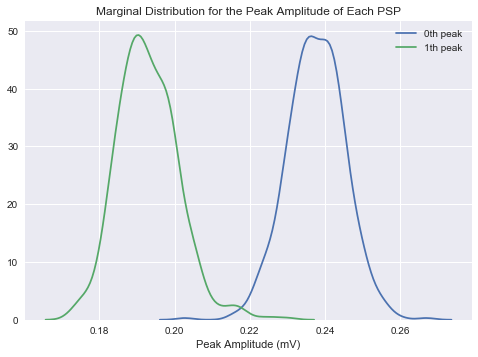

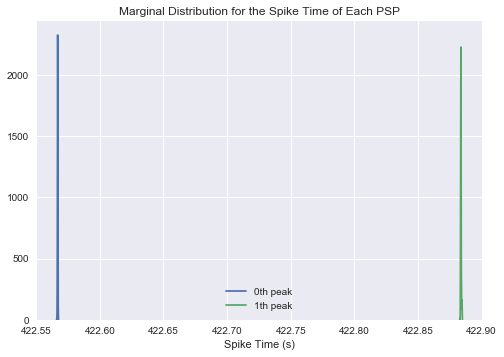

In [13]:
num_psp = two_psp_randomly_reduced.num_psp
t_end = two_psp_randomly_reduced.data['T'].iloc[-1]
fig1 = plt.figure()
for i in range(num_psp):
    df = neuronal.calculate_peak_amplitudes(i, two_psp_randomly_reduced_df, t_end, num_psp)
    quantile_df = neuronal.get_quantiles(df.loc[:, ['t_psp__' + str(i), 'peak_amp__' + str(i)]])
    neuronal.report_best_fit(quantile_df, 't_psp__' + str(i))
    neuronal.report_best_fit(quantile_df, 'peak_amp__' + str(i))
    sns.kdeplot(df['peak_amp__' + str(i)], label=str(i)+'th peak')
plt.xlabel('Peak Amplitude (mV)')
plt.title('Marginal Distribution for the Peak Amplitude of Each PSP')
plt.show()

fig2 = plt.figure()
for i in range(num_psp):
    sns.kdeplot(df['t_psp__' + str(i)], label=str(i)+'th peak')
plt.xlabel('Spike Time (s)')
plt.title('Marginal Distribution for the Spike Time of Each PSP')
plt.show()

The marginal distributions from the randomly reduced data appear to be more asymmetric than those from the data reduced via $\textbf{decimate}$ method. Their 68% credible intervals overlap fairly well however. 

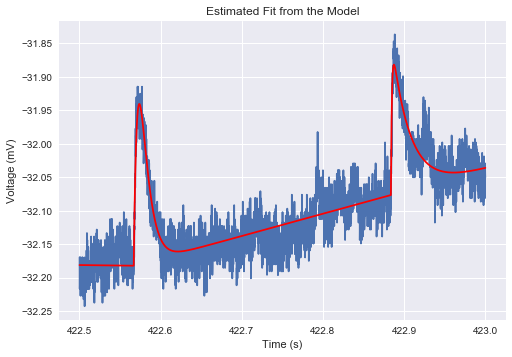

In [14]:
neuronal.plot_fit(two_psp, two_psp_randomly_reduced_df)

The resulting parameters from the randomly reduced data seem to lead to a decent fit on the original data as well. However, based on this particular, original data set, it seems better to use the $\textbf{decimate}$ method because it leads to more symmetric marginal distributions of the parameters. 

## Using Simulated Data for Evaluation

By simulating the data with our own generative model, we can check whether our package is working properly or not. Given that our model is 100% correct when we test it against the data simulated with our own model, we can check whether the No U-Turn Sampler (NUTS) from pymc3 can effectively find the true parameter values even when the initial guess is somewhat off from the true values.

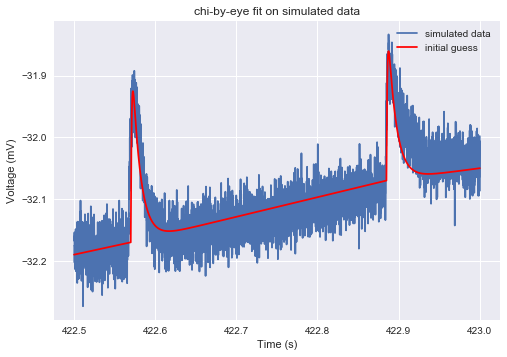

In [39]:
#Generate simulated data using the estimated parameters from the above pymc3 calculation
quantile_df_simulate = neuronal.get_quantiles(two_psp_df)
b_start_simulate = quantile_df_simulate.loc[0.50, 'b_start']
b_end_simulate = quantile_df_simulate.loc[0.50, 'b_end']
sigma_simulate = quantile_df_simulate.loc[0.50, 'sigma']

b_simulate = np.zeros(two_psp.num_psp)
a_simulate = np.zeros(two_psp.num_psp)
t_psp_simulate = np.zeros(two_psp.num_psp)
tau_d_simulate = np.zeros(two_psp.num_psp)
tau_r_simulate = np.zeros(two_psp.num_psp)
for i in range(two_psp.num_psp):
    b_simulate[i] = quantile_df_simulate.loc[0.50, 'b__'+str(i)]
    a_simulate[i] = quantile_df_simulate.loc[0.50, 'a__'+str(i)]
    t_psp_simulate[i] = quantile_df_simulate.loc[0.50, 't_psp__'+str(i)]
    tau_d_simulate[i] = quantile_df_simulate.loc[0.50, 'tau_d__'+str(i)]
    tau_r_simulate[i] = quantile_df_simulate.loc[0.50, 'tau_r__'+str(i)]

t_range_simulate = (t[0], t[-1])
step_simulate = 1/9415 #9415 Hz is the sampling frequency we used in the experiment

simulated_data = neuronal.simulate_psp_data(sigma_simulate, b_start_simulate, b_simulate, 
                                            b_end_simulate, a_simulate, t_psp_simulate, tau_d_simulate,
                                            tau_r_simulate, t_range_simulate, step_simulate)

#Same set of initial guess as what we used for above pymc3 calculations
sigma_guess = 0.026
b_start_guess = -32.19
b_guess = [-32.17, -32.07]
b_end_guess = -32.05
a_guess = [0.35, 0.3]
t_psp_guess = [422.57, 422.885]
tau_d_guess = [0.01, 0.01]
tau_r_guess = [0.001, 0.001]

model_guess = neuronal.psp_model(two_psp, b_start_guess, b_guess, b_end_guess, a_guess, t_psp_guess, tau_d_guess, tau_r_guess)

plt.plot(simulated_data.data['T'], simulated_data.data['V'], label='simulated data')
plt.plot(t, model_guess, c='r', label='initial guess')
plt.legend()
plt.title('chi-by-eye fit on simulated data')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.show()

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_r, tau_d, t_psp, a, sigma, b, b_end, b_start]
Sampling 2 chains: 100%|██████████| 1000/1000 [02:38<00:00,  4.94draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9500261956318424, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.955522934385233, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


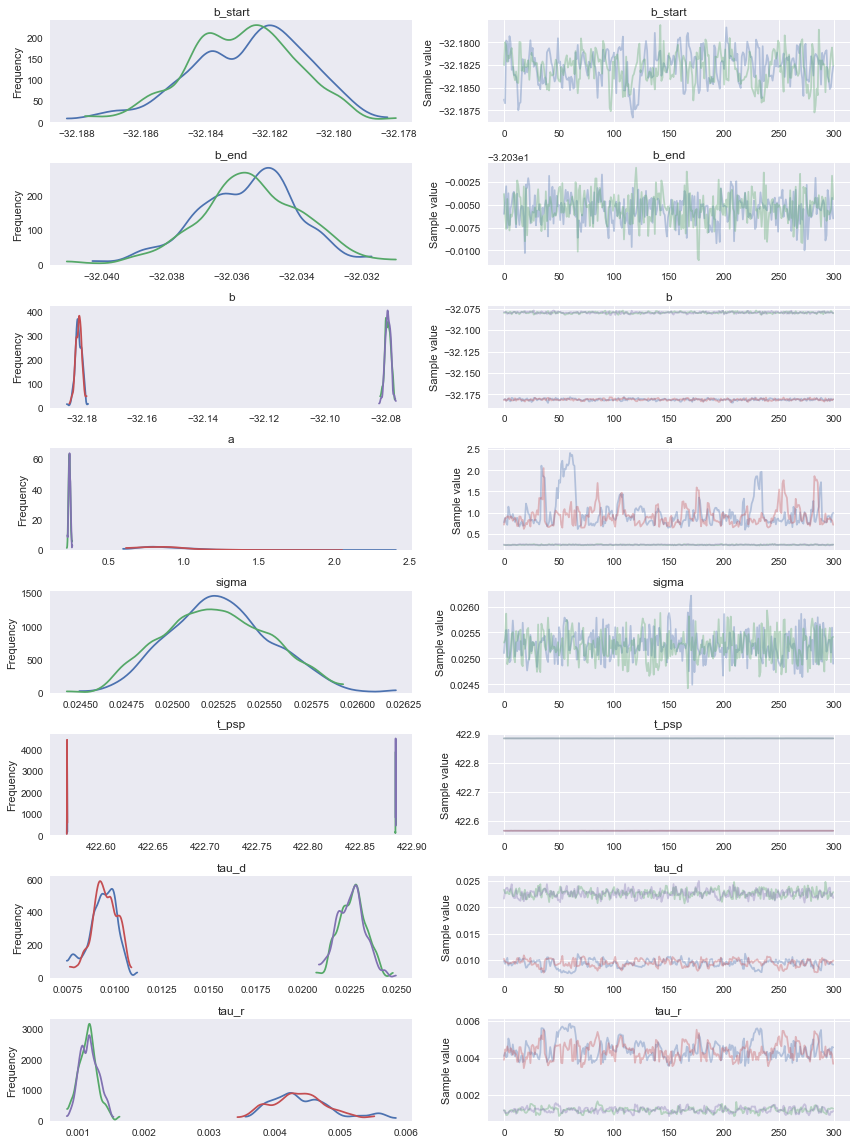

In [33]:
initial_guess = {'sigma': sigma_guess, 'b_start': b_start_guess, 'b': b_guess, 'b_end': b_end_guess,
                 'a': a_guess, 't_psp': t_psp_guess, 'tau_d': tau_d_guess, 'tau_r': tau_r_guess}

simulated_data_df = neuronal.psp_fit(simulated_data, 300, initial_guess, seed=1000, tune=200, cores=2)

The best fit value for t_psp__0 is 422.5671 + 0.0001 - 0.0001
The best fit value for peak_amp__0 is 0.2401 + 0.0033 - 0.0031
The best fit value for t_psp__1 is 422.8839 + 0.0001 - 0.0001
The best fit value for peak_amp__1 is 0.1935 + 0.0036 - 0.0031


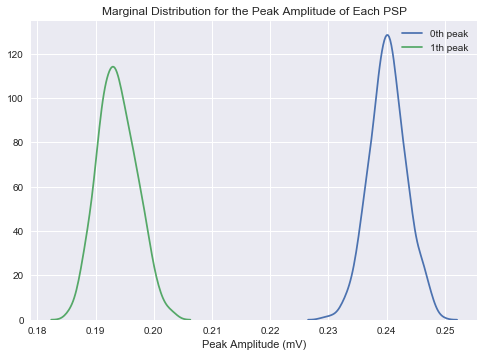

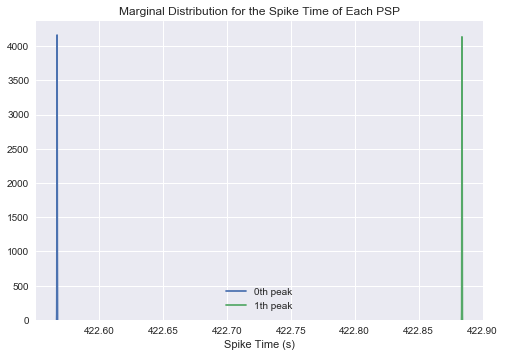

In [34]:
num_psp = simulated_data.num_psp
t_end = simulated_data.data['T'].iloc[-1]
fig1 = plt.figure()
for i in range(num_psp):
    df = neuronal.calculate_peak_amplitudes(i, simulated_data_df, t_end, num_psp)
    quantile_df = neuronal.get_quantiles(df.loc[:, ['t_psp__' + str(i), 'peak_amp__' + str(i)]])
    neuronal.report_best_fit(quantile_df, 't_psp__' + str(i))
    neuronal.report_best_fit(quantile_df, 'peak_amp__' + str(i))
    sns.kdeplot(df['peak_amp__' + str(i)], label=str(i)+'th peak')
plt.xlabel('Peak Amplitude (mV)')
plt.title('Marginal Distribution for the Peak Amplitude of Each PSP')
plt.show()

fig2 = plt.figure()
for i in range(num_psp):
    sns.kdeplot(df['t_psp__' + str(i)], label=str(i)+'th peak')
plt.xlabel('Spike Time (s)')
plt.title('Marginal Distribution for the Spike Time of Each PSP')
plt.show()

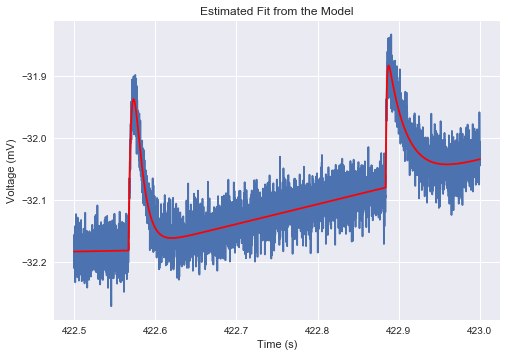

In [35]:
neuronal.plot_fit(simulated_data, simulated_data_df)

In [38]:
#Set of parameters estimated from pymc3 calculation
simulated_data_quantile_df = neuronal.get_quantiles(simulated_data_df)
simulated_data_quantile_df

,b_start,b_end,b__0,b__1,a__0,a__1,sigma,t_psp__0,t_psp__1,tau_d__0,tau_d__1,tau_r__0,tau_r__1,peak_amp__0,peak_amp__1
0.16,-32.184484,-32.037054,-32.182011,-32.080422,0.723381,0.235350,0.024956,422.567030,422.883846,0.008721,0.021860,0.003918,0.001013,0.237057,0.190461
0.50,-32.182647,-32.035413,-32.180988,-32.079514,0.876037,0.241270,0.025236,422.567118,422.883932,0.009392,0.022639,0.004355,0.001158,0.240128,0.193540
0.84,-32.181002,-32.033957,-32.179862,-32.078497,1.137690,0.247767,0.025548,422.567222,422.884027,0.010105,0.023338,0.004863,0.001299,0.243391,0.197094


In [40]:
#Set of parameters used to simulate the data
quantile_df_simulate

,b_start,b_end,b__0,b__1,a__0,a__1,sigma,t_psp__0,t_psp__1,tau_d__0,tau_d__1,tau_r__0,tau_r__1,peak_amp__0,peak_amp__1
0.16,-32.184479,-32.038750,-32.182673,-32.081156,0.764468,0.236535,0.024959,422.566815,422.883815,0.008775,0.022190,0.004127,0.001063,0.237726,0.190410
0.50,-32.182879,-32.037039,-32.181545,-32.080257,0.932204,0.242574,0.025218,422.566922,422.883933,0.009417,0.022913,0.004589,0.001202,0.240781,0.193602
0.84,-32.181170,-32.035302,-32.180390,-32.079302,1.228924,0.248305,0.025470,422.567021,422.884064,0.010107,0.023747,0.005116,0.001347,0.244500,0.197041


In [41]:
#Our initial guess
sigma_guess = 0.026
b_start_guess = -32.19
b_guess = [-32.17, -32.07]
b_end_guess = -32.05
a_guess = [0.35, 0.3]
t_psp_guess = [422.57, 422.885]
tau_d_guess = [0.01, 0.01]
tau_r_guess = [0.001, 0.001]

Our initial guess was pretty good for some parameters (e.g. t_psp__1), but was pretty bad (off upto a factor of ~4.6) for some other parameters (e.g. tau_r__0). Nevertheless, even with a small number of samples (300), pymc3 was able to estimate parameters that agree (within 68% credible interval range) with the actual values used for simulating the data.

## Reference

1.	Obien, M. E. J., Deligkaris, K., Bullmann, T., Bakkum, D. J., & Frey, U. Revealing neuronal function through microelectrode array recordings. $\textit{Front. Neurosci.}$ $\textbf{8}$, 423 (2015)

2.	Merel, J., Shababo, B., Naka, A., Adesnik, H., & Paninski, L. Bayesian methods for event analysis of intracellular currents. $\textit{J. Neurosci. Methods}$ $\textbf{269}$, 21-32 (2016)

3.	Abbott, J. et al. CMOS nanoelectrode array for all-electrical intracellular electrophysiological imaging. $\textit{Nat. Nanotechnol.}$ $\textbf{12}$, 460 (2017).

4.	Salvatier, J., Wiecki, T. V., & Fonnesbeck, C. Probabilistic programming in Python using PyMC3. $\textit{PeerJ Comput. Sci.}$ $\textbf{2}$, e55 (2016) 
